# Fast DGSEM block inversion

In this notebook, we test the methods analytical formulations for DGSEM-matrix inversion against classical `numpy` tools. We also time them to see which is the most efficient one.

To test for exactness, we relying on a classical Frobenius norm of the differnce between the proposed analytical formulae and the reference one.

The performances will be measured with `jupyter`/`IPython` `[%]%timeit` magic (see the header of the related cells). To compute fair statistics, we use 20 runs (see option `-r 20`): hence, running the notebook might take some time.

In [1]:
import numpy as np

import fast_DGSEM_block_inversion as f_dgsem

In [2]:
# Polynomial order
p = 2  # Accepted: 1:5 included

# Celerity*time step over spatial grid size
lambda_x, lambda_y = 1.0, 1.0

## Exactness

In [3]:
_ = f_dgsem.compare_eigenvalues_computation(p)

Verification of L eigenvalues (difference inf. norm between the two methods): 2.7599706730399138e-15



In [4]:
_ = f_dgsem.compare_2D_inversion(p, lambda_x, lambda_y)

Verification of diag. block inv. (difference inf. norm between the two methods): 8.060194330240908e-15



In [5]:
_ = f_dgsem.compare_2D_inversion_viscosity(p, lambda_x, lambda_y)

Verification of diag. block inv. with graph visc. (difference inf. norm between the two methods): 3.397083113300733e-14


## Performances

We compare the performances of the reference solution with `numpy` and the proposed analytical formulae for the inversion of 2D problems with and without graph viscosity. We compute some matrices only at the beginning and reuse them in the runs for the performance evaluation: notice that this is similar to what one would do when solving an unsteady problem. Indeed, the pre-computed matrices would not change over the time-step and are of small dimension, so that they can be easily stored.

In [6]:
perf_res = {}  # Store results
for p, lobatto_weights in f_dgsem.LOBATTO_WEIGHTS_BY_ORDER.items():
    print(f"---------------- Assessing order p={p} ----------------")
    # Setting up variables and reusable matrices

    # Derivative matrix
    D = f_dgsem.D_matrix(p)
    # Mass matrix
    M_diag = f_dgsem.mass_matrix_diag(p)
    # Eigen-values and -vectors
    psi = f_dgsem.eigen_L_analytical(D)
    R = f_dgsem.R_matrix(D, psi)
    #temp arrays for numpy inversion
    I = np.eye(p + 1)
    Omega = lobatto_weights.reshape((p + 1, 1))
    IOmega = np.kron(I, Omega)
    OmegaI = np.kron(Omega, I)
    VvT = np.transpose(
        np.concatenate(
            (np.kron(I, np.ones((p + 1, 1))), np.kron(np.ones((p + 1, 1)), I)), axis=1
        )
    )
    #temp arrays for analytical inversion
    invR = np.linalg.inv(R)
    invMR = f_dgsem.diagonal_matrix_multiply(np.reciprocal(M_diag), R)
    M2d_invdiag = np.reciprocal(f_dgsem.diagonal_auto_kron(M_diag))
    invROmega = np.dot(invR, Omega) 
    R2d = np.kron(R, R)
    iR2d = np.kron(invR, invR)
    iMR2d = np.kron(invMR, invMR)
    invRROmega = np.kron(invR, invROmega)
    invROmegaR = np.kron(invROmega, invR)
    # res = %timeit -o captures the result and stores it in res
    res_p = {}
    print("* L2 inversion:")
    print("  - {:10s}: ".format("numpy"), end="")
    res = %timeit -o -r 20 f_dgsem.L2d_inversion_numpy(D, M_diag, lambda_x, lambda_y)
    res_p["L2d_inv_numpy"] = res.average
    res_p["L2d_inv_numpy_std"] = res.stdev
    print("  - Analytical: ", end="")
    res = %timeit -o -r 20 f_dgsem.L2d_inversion_analytical(D, M_diag, lambda_x, lambda_y, psi, iR2d, iMR2d)
    res_p["L2d_inv_analytical"] = res.average
    res_p["L2d_inv_analytical_std"] = res.stdev
    print("* L2 inversion with graph viscosity:")
    print("  - {:10s}: ".format("numpy"), end="")
    res = %timeit -o -r 20 f_dgsem.L2d_inversion_viscosity_numpy(D, M2d_invdiag, lambda_x, lambda_y, VvT, IOmega, OmegaI)
    res_p["L2d_inv_vis_numpy"] = res.average
    res_p["L2d_inv_vis_numpy_std"] = res.stdev
    print("  - Analytical: ", end="")
    res = %timeit -o -r 20 f_dgsem.L2d_inversion_viscosity_analytical(D, M2d_invdiag, lambda_x, lambda_y, psi, R2d, iR2d, VvT, invRROmega, invROmegaR)
    res_p["L2d_inv_vis_analytical"] = res.average
    res_p["L2d_inv_vis_analytical_std"] = res.stdev
    
    perf_res[p] = res_p
    print()

---------------- Assessing order p=1 ----------------
* L2 inversion:
  - numpy     : 95.1 µs ± 3.25 µs per loop (mean ± std. dev. of 20 runs, 10,000 loops each)
  - Analytical: 13.2 µs ± 168 ns per loop (mean ± std. dev. of 20 runs, 100,000 loops each)
* L2 inversion with graph viscosity:
  - numpy     : 128 µs ± 1.17 µs per loop (mean ± std. dev. of 20 runs, 10,000 loops each)
  - Analytical: 94 µs ± 1.2 µs per loop (mean ± std. dev. of 20 runs, 10,000 loops each)

---------------- Assessing order p=2 ----------------
* L2 inversion:
  - numpy     : 172 µs ± 15.4 µs per loop (mean ± std. dev. of 20 runs, 10,000 loops each)
  - Analytical: 16.2 µs ± 63 ns per loop (mean ± std. dev. of 20 runs, 100,000 loops each)
* L2 inversion with graph viscosity:
  - numpy     : 223 µs ± 32.4 µs per loop (mean ± std. dev. of 20 runs, 1,000 loops each)
  - Analytical: 163 µs ± 12 µs per loop (mean ± std. dev. of 20 runs, 10,000 loops each)

---------------- Assessing order p=3 ----------------
* L2 

In [7]:
import pandas as pd

In [8]:
perf = pd.DataFrame.from_dict(perf_res, orient="index")
perf.index.name = "order"
perf *= 1e6  # From sec to µsec
perf["L2d_inv_speed_up"] = perf["L2d_inv_numpy"] / perf["L2d_inv_analytical"]
perf["L2d_inv_vis_speed_up"] = perf["L2d_inv_vis_numpy"] / perf["L2d_inv_vis_analytical"]
print("Total results in [µs]:")
perf  # Using default render of jupyter instead of print() for better visualitzation

Total results in [µs]:


,L2d_inv_numpy,L2d_inv_numpy_std,L2d_inv_analytical,L2d_inv_analytical_std,L2d_inv_vis_numpy,L2d_inv_vis_numpy_std,L2d_inv_vis_analytical,L2d_inv_vis_analytical_std,L2d_inv_speed_up,L2d_inv_vis_speed_up
order,,,,,,,,,,
1,95.063496,3.251588,13.179985,0.168101,127.597528,1.171861,93.987860,1.203603,7.212717,1.357596
2,171.852207,15.429618,16.212278,0.063044,223.104270,32.415526,162.547499,11.981678,10.600127,1.372548
3,191.510312,3.673328,19.925487,0.411907,248.190696,63.513774,183.475366,11.073428,9.611324,1.352719
4,234.193385,64.268662,25.870608,0.760318,280.724003,61.938440,221.158162,42.633868,9.052489,1.269336
5,272.177769,57.628014,68.727145,5.796564,330.729600,66.958662,272.486300,58.517333,3.960266,1.213748
6,314.009352,42.093561,90.522700,9.643601,373.546834,53.575089,339.832974,43.191528,3.468847,1.099207


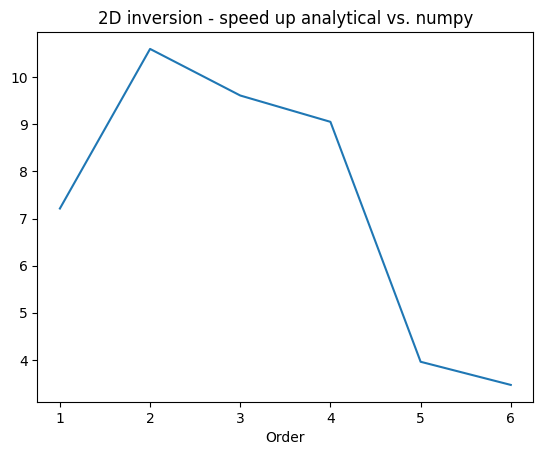

In [9]:
ax = perf.plot(use_index=True, y="L2d_inv_speed_up", legend=False)
_ = ax.set_title("2D inversion - speed up analytical vs. numpy")
_ = ax.set_xlabel("Order")

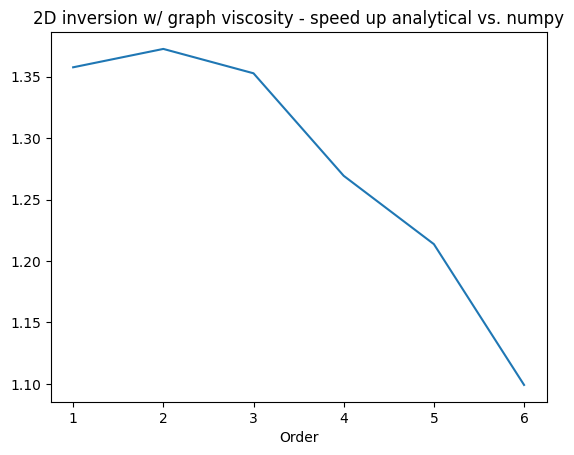

In [10]:
ax = perf.plot(use_index=True, y="L2d_inv_vis_speed_up", legend=False)
_ = ax.set_title("2D inversion w/ graph viscosity - speed up analytical vs. numpy")
_ = ax.set_xlabel("Order")

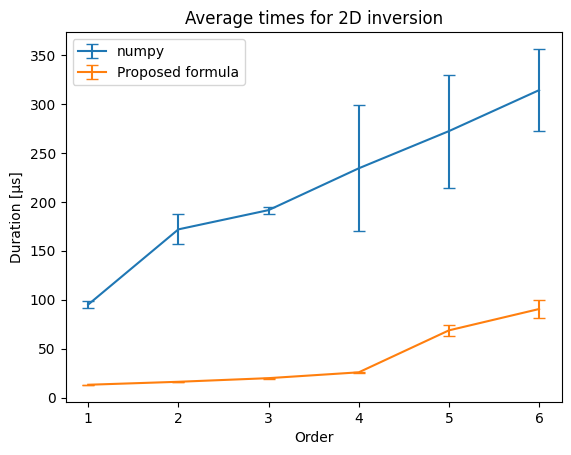

In [11]:
ax = perf.plot(use_index=True, y="L2d_inv_numpy", yerr="L2d_inv_numpy_std", capsize=4)
_ = perf.plot(use_index=True, y="L2d_inv_analytical", yerr="L2d_inv_analytical_std", capsize=4, ax=ax)
_ = ax.set_title("Average times for 2D inversion")
_ = ax.set_xlabel("Order")
_ = ax.set_ylabel("Duration [µs]")
_ = ax.legend(["numpy", "Proposed formula"])

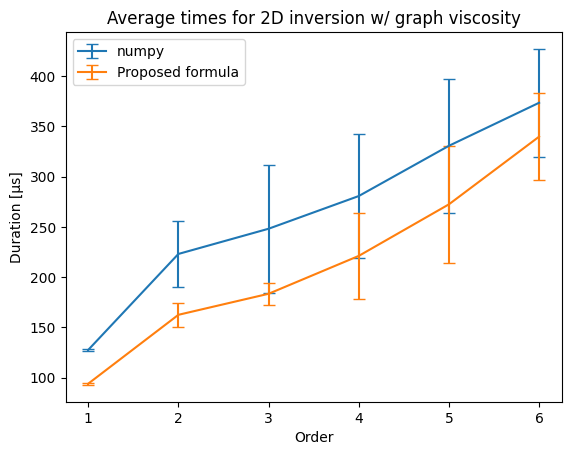

In [12]:
ax = perf.plot(use_index=True, y="L2d_inv_vis_numpy", yerr="L2d_inv_vis_numpy_std", capsize=4)
_ = perf.plot(use_index=True, y="L2d_inv_vis_analytical", yerr="L2d_inv_vis_analytical_std", capsize=4, ax=ax)
_ = ax.set_title("Average times for 2D inversion w/ graph viscosity")
_ = ax.set_xlabel("Order")
_ = ax.set_ylabel("Duration [µs]")
_ = ax.legend(["numpy", "Proposed formula"])